Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Past Methods for Time Series Forecasting - Holt Winters

* Python Holt Winters: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import itertools
import timeit
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

## Data Preparation


* Whole sequence ts - Training with all the training data and testing with all the testing data.
  * ts_df_train, ts_df_test
* Relative train & test pairs - For each (train, test) pair, the training data was the selected historical data that's relevant to the testing data
* Adjustable rolling window - The whole training data is splitted into (train, validation) pairs, for adjustable training
* Selected training subset - The whole training data was selected from a subset of the original training data

In [2]:
ts_df = pd.read_pickle('../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df.head()

(942, 1)


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


In [3]:
def count_dct_seq_len(seq_dct):
    """
    Count each unique sequence length in the doctionary.
    
    @param seq_dct: A dictionary that stores sequences.
    @return: The count of each unique sequence.
    """
    ct_dct = {}
    
    for i in range(len(seq_dct)):
        elems_len = [len(e) for e in seq_dct[i].values()]
        ct_dct.setdefault(f'{elems_len}', 0)
        ct_dct[f'{elems_len}'] += 1
        
    return ct_dct


def get_relative_train_test_pairs(train_ts, test_ts, train_window, test_window, test_stride):
    """
    Spliting the training and testing data in (train, test) pairs, each pair has historical time matches to the current time.
    The stride length between training windows and testing windows are all as long as the test_window.
    Window size and stride length are all measured in months.
    
    @param train_ts: The original training data.
    @param test_ts: The original testing data.
    @param train_window: The window length of the splited training data.
    @param test_window: The window length of the splited testing data.
    @param test_stride: The length that test window moves.
    @return: A dictionary where stores the index and each (train, test) pair.
    """
    train_month_set = set(train_ts.index.month)
    test_month_set = set(test_ts.index.month)
    
    if test_month_set.issubset(train_month_set) == False:
        raise ValueError('This method is only used when testing month list is a subset of training month list.')
        
    pair_idx = 0
    train_test_dct = {}
    
    test_idx = 0
    train_month_lst = list(train_month_set)
    train_month_lst.sort()
    test_month_lst = list(test_month_set)
    test_month_lst.sort()
    while test_idx + max(test_stride, test_window) < len(test_month_set):
        test_seq = test_ts.iloc[(test_ts.index.month >= test_month_lst[test_idx]) & (test_ts.index.month <= test_month_lst[test_idx + test_window - 1])]
        relative_train_months = [m for m in train_month_lst if m <= test_month_lst[test_idx]][-train_window:]
        train_seq = train_ts.iloc[(train_ts.index.month >= relative_train_months[0]) & (train_ts.index.month <= relative_train_months[-1])]
        
        train_test_dct[pair_idx] = {'train': train_seq, 'test': test_seq}
        
        test_idx += test_stride
        pair_idx += 1
        
    test_seq = test_ts.iloc[test_ts.index.month >= test_month_lst[test_idx]]
    relative_train_months = [m for m in train_month_lst if m <= test_month_lst[test_idx]][-train_window:]
    train_seq = train_ts.iloc[(train_ts.index.month >= relative_train_months[0]) & (train_ts.index.month <= relative_train_months[-1])]
    train_test_dct[pair_idx] = {'train': train_seq, 'test': test_seq}
    
    return train_test_dct


def get_train_valid_rolling_windows(ts, train_window, valid_window):
    """
    It divide a time series into (train, validation) pairs through sliding windows. 
    The stride length between training windows and validation windows are all as long as the valid_window.
    
    @param ts: The whole time series. Its index is the date.
    @param train_window: The windows length of the training data in a pair.
    @param valid_window: The window length of the validation data in a pair.
    @return: A dictionary where stores the index and each (train, validation) pair.
    """
    seq_idx = 0
    train_valid_dct = {}
    
    train_idx = 0
    
    while train_idx <= len(ts)-train_window-valid_window:
        train_seq = ts[train_idx:train_idx+train_window]
        valid_seq = ts[train_idx+train_window:train_idx+train_window+valid_window]
        
        train_valid_dct[seq_idx] = {'train': train_seq, 'valid': valid_seq}
        
        train_idx += valid_window
        seq_idx += 1
        
    train_seq = ts[train_idx:train_idx+train_window]
    valid_seq = ts[train_idx+train_window:]
    train_valid_dct[seq_idx] = {'train': train_seq, 'valid': valid_seq}
        
    return train_valid_dct

In [4]:
# Whole sequence ts
ts_df_train = ts_df.iloc[ts_df.index < '2015-03-01']
ts_df_test = ts_df.iloc[ts_df.index >= '2015-03-01']
print('Whole Sequence ts:', ts_df_train.shape, ts_df_test.shape)

Whole Sequence ts: (789, 1) (153, 1)


In [5]:
# Relative train & test pairs
relative_train_test_pairs = get_relative_train_test_pairs(ts_df_train, ts_df_test, train_window=3, test_window=1, test_stride=1)

ct_dct = count_dct_seq_len(relative_train_test_pairs)
print(ct_dct)

{'[239, 31]': 1, '[206, 30]': 1, '[184, 31]': 2, '[182, 30]': 1}


In [6]:
# Adjustable rolling window
rolling_window_train_valid_dct = get_train_valid_rolling_windows(ts_df_train, train_window=110, valid_window=20)

ct_dct = count_dct_seq_len(rolling_window_train_valid_dct)
print(ct_dct)

{'[110, 20]': 33, '[110, 19]': 1}


In [7]:
# Selected training subset
ts_df_train_sub = ts_df_train.iloc[ts_df_train.index >= '2014-03-01']

print(ts_df_train_sub.shape)

(365, 1)


In [8]:
# This dictionary records all the performance
summarized_performance = {}

## Whole Sequence Forecasting

In [9]:
def get_runtime(method):
    """
    This is a decorator function to get the execution time of a function.
    
    @param method: the function that uses this decorator.
    """
    def timed(*args):
        ts = timeit.default_timer()
        result = method(*args)
        te = timeit.default_timer()
        print(f'Execution Time: {te - ts} seconds')
        return result
    return timed


def hw_forecast(train_ts, test_ts, selected_params, title):
    """
    Forecast and plot the train, test & forecasted time series.
    
    @param train_ts: the training time series data
    @param test_ts: the testing time series data
    @param selected_params: the selected params for this forecast
    @param title: the title of the plot
    @return: return the forecast performance results
    """
    model_fit = ExponentialSmoothing(np.asarray(train_ts), 
                                     seasonal_periods=selected_params['seasonal_periods'], trend=selected_params['trend'],
                                     seasonal=selected_params['seasonal'], damped=selected_params['damped'])\
                .fit(smoothing_level=selected_params['smoothing_level'], smoothing_slope=selected_params['smoothing_slope'])
    y_pred = model_fit.forecast(len(test_ts))
    
    pred_mape = mape(test_ts, y_pred)
    pred_r2 = r2_score(test_ts, y_pred)
    
    plt.figure(figsize=(20,7))
    plt.plot(train_ts.index, train_ts, label='Train')
    plt.plot(test_ts.index, test_ts, label='Test')
    plt.plot(test_ts.index, y_pred, label='Forecast')
    plt.legend(loc='best')
    plt.title(f'{title} (MAPE: {pred_mape}, R2: {pred_r2})')
    plt.show()
    
    return pred_mape, pred_r2

### Forecast without Parameter Tuning

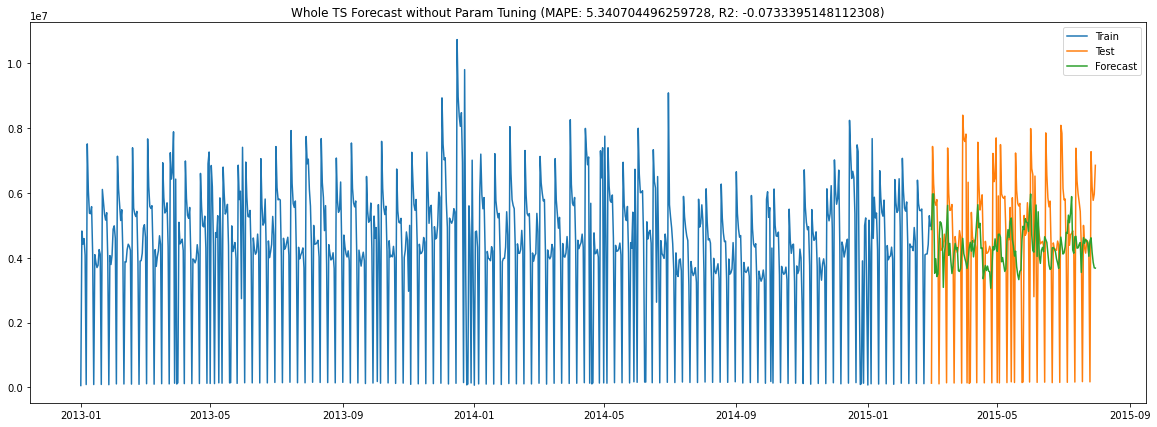

In [10]:
selected_params0 = {'seasonal_periods': 160, 'trend': 'mul', 'seasonal': 'mul', 'damped': True, 'smoothing_level': 0.9, 'smoothing_slope': 0.2}
whole_pred_mape_no_hpo, whole_pred_r2_no_hpo = hw_forecast(ts_df_train, ts_df_test, selected_params0, title='Whole TS Forecast without Param Tuning')

summarized_performance[0] = {'Experiment': 'Whole Sequence without HPO', 'MAPE': whole_pred_mape_no_hpo, 'R2': whole_pred_r2_no_hpo}

### Parameter Tuning Without Backtesting
* Grid Search is used for param tuning here
* Validation data size is the same as testing data size

In [11]:
@get_runtime
def hw_grid_search(params_dct, train_ts, valid_ts):
    """
    Grid search for param tuning, without backtesting.
    
    @param params_dct: a dictionary of all the params' choices
    @param train_ts: the training data used for training
    @param valid_ts: the validation data used for forecast validation
    @return: the selected params
    """
    best_mape = np.inf
    best_params = None
    
    # list all the param sets for the grid search
    grid_params = list(itertools.product(params_dct['seasonal_periods'], params_dct['trend'], params_dct['seasonal'],
                                         params_dct['damped'], params_dct['smoothing_level'], params_dct['smoothing_slope']))
    
    for params in grid_params:
        try:
            model_fit = ExponentialSmoothing(np.asarray(train_ts), 
                                     seasonal_periods=params[0], trend=params[1],
                                     seasonal=params[2], damped=params[3])\
                        .fit(smoothing_level=params[4], smoothing_slope=params[5])
            y_pred = model_fit.forecast(len(valid_ts))

            pred_mape = mape(valid_ts, y_pred)
            if pred_mape < best_mape:
                best_mape = pred_mape
                best_params = params
        except:
            pass
        
    selected_params = {'seasonal_periods': best_params[0], 'trend': best_params[1], 'seasonal': best_params[2], 
                       'damped': best_params[3], 'smoothing_level': best_params[4], 'smoothing_slope': best_params[5]}
    print(f'After trying {len(grid_params)} param sets, got best MAPE as {best_mape} through param set {selected_params}')
            
    return selected_params

In [12]:
params_dct = {
    'seasonal_periods': range(150, 170, 5),
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'damped': [True],
    'smoothing_level': [0.2, 0.6, 0.8, 0.9],
    'smoothing_slope': [0.2, 0.4, 0.6, 0.8]
}

hpo_train_size = ts_df_train.shape[0] - ts_df_test.shape[0]
print(hpo_train_size)
train_ts = ts_df_train.iloc[0:hpo_train_size]
valid_ts = ts_df_train.iloc[hpo_train_size:]
selected_params1 = hw_grid_search(params_dct, train_ts, valid_ts)

636
After trying 256 param sets, got best MAPE as 1.1551596016987635 through param set {'seasonal_periods': 150, 'trend': 'add', 'seasonal': 'mul', 'damped': True, 'smoothing_level': 0.9, 'smoothing_slope': 0.4}
Execution Time: 183.1739891 seconds


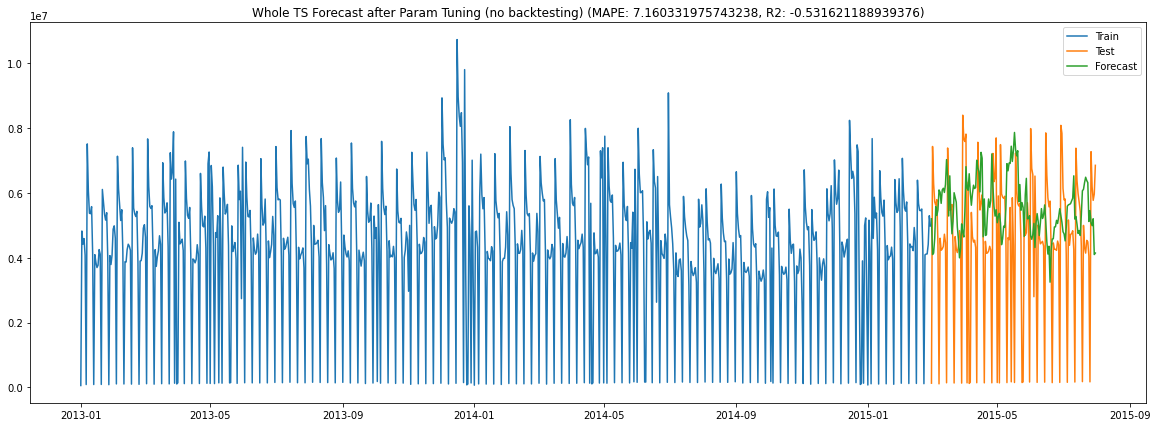

In [13]:
whole_pred_mape_hpo, whole_pred_r2_hpo = hw_forecast(ts_df_train, ts_df_test, selected_params1, title='Whole TS Forecast after Param Tuning (no backtesting)')

summarized_performance[1] = {'Experiment': 'Whole Sequence HPO without Backtesting', 'MAPE': whole_pred_mape_hpo, 'R2': whole_pred_r2_hpo}

### Parameter Tuning with Backtesting

* Grid Search is used for param tuning here
* Validation data size is the same as testing data size
* Note: When using `ExponentialSmoothing`, make sure the training size >= validation (or testing) size

In [14]:
@get_runtime
def hw_grid_search_backtest(params_dct, train_ts, valid_size, splits=5):
    """
    Grid search for param tuning with backtesting.
    
    @param params_dct: a dictionary of all the params' choices
    @param train_ts: the training data that's going to be split into (train, valid) pairs for backtesting
    @param valid_size: limit the validation data size in backtesting, it should not be larger than the training data in each split
    @param splits: the number of splits for backtesting
    @return: the selected params
    """
    best_mape = np.inf
    best_params = None
    
    # list all the param sets for the grid search
    grid_params = list(itertools.product(params_dct['seasonal_periods'], params_dct['trend'], params_dct['seasonal'],
                                         params_dct['damped'], params_dct['smoothing_level'], params_dct['smoothing_slope']))
    
    for params in grid_params:
        try:
            tscv = TimeSeriesSplit(n_splits=splits, test_size=valid_size)
            total_mape = 0
            
            for train_idx, valid_idx in tscv.split(train_ts):
                train = train_ts.iloc[train_idx]
                valid = train_ts.iloc[valid_idx]
            
                model_fit = ExponentialSmoothing(np.asarray(train), 
                                         seasonal_periods=params[0], trend=params[1],
                                         seasonal=params[2], damped=params[3])\
                            .fit(smoothing_level=params[4], smoothing_slope=params[5])
                y_pred = model_fit.forecast(len(valid))
                pred_mape = mape(valid, y_pred)
                total_mape += pred_mape
                
            avg_mape = total_mape/splits
            if avg_mape < best_mape:
                best_mape = avg_mape
                best_params = params
        except:
            pass
        
    selected_params = {'seasonal_periods': best_params[0], 'trend': best_params[1], 'seasonal': best_params[2], 
                       'damped': best_params[3], 'smoothing_level': best_params[4], 'smoothing_slope': best_params[5]}
    print(f'After trying {len(grid_params)} param sets, got best average MAPE as {best_mape} through param set {selected_params}')
            
    return selected_params

In [15]:
params_dct = {
    'seasonal_periods': range(150, 170, 5),
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'damped': [True],
    'smoothing_level': [0.2, 0.6, 0.8, 0.9],
    'smoothing_slope': [0.2, 0.4, 0.6, 0.8]
}

selected_params2 = hw_grid_search_backtest(params_dct, ts_df_train, len(ts_df_test), 3)

After trying 256 param sets, got best average MAPE as 4.498129711123074 through param set {'seasonal_periods': 165, 'trend': 'mul', 'seasonal': 'mul', 'damped': True, 'smoothing_level': 0.9, 'smoothing_slope': 0.6}
Execution Time: 437.2284641 seconds


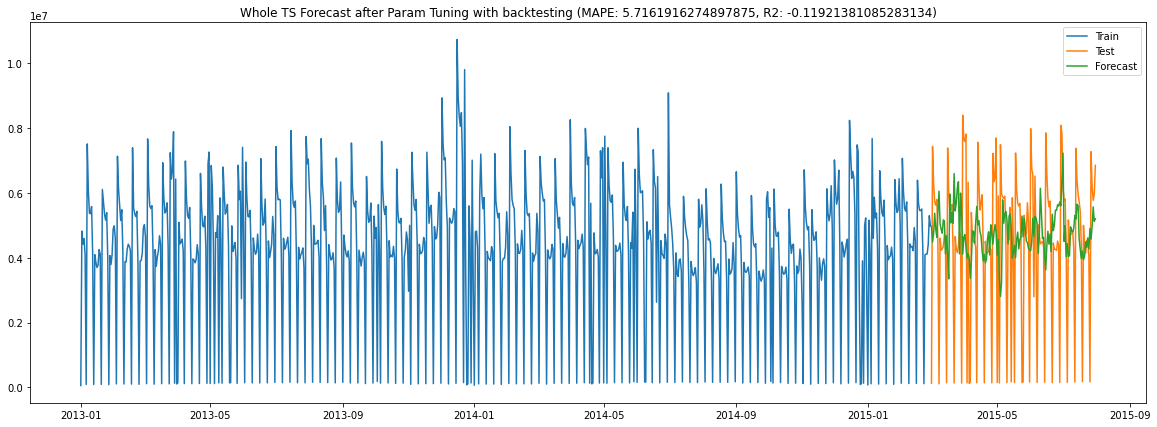

In [16]:
whole_pred_mape_hpo_bt, whole_pred_r2_hpo_bt = hw_forecast(ts_df_train, ts_df_test, selected_params2, title='Whole TS Forecast after Param Tuning with backtesting')

summarized_performance[2] = {'Experiment': 'Whole Sequence HPO with Backtesting', 'MAPE': whole_pred_mape_hpo_bt, 'R2': whole_pred_r2_hpo_bt}

## Relative (train, test) Pairs Forecasting

* It assumes the same period of each years share similar time series patterns.
* Within each (train, test) pair:
  * Train a model using the training data, using param tuning with back test
  * Evaluate on the testing data
* The overall testing evaluation is the aggregated performance from all pairs
* Note: this approach is too complex to be used. Complex in creating data input, also complex in evaluation. Performance won't make significant improvement. Don't suggest to use this method in practice.

In [17]:
@get_runtime
def hw_grid_search_backtest_relative_train_test_pairs(params_dct, relative_train_test_pairs, splits=3):
    """
    Grid search for each relative (train, test) pair.
    
    @param params_dct: a dictionary of all the params' choices
    @param relative_train_test_pairs: all the relative (train, test) pairs
    @param splits: the number of splits for backtesting
    @return: selected params and best average validation performance of each relative (train, test) pairs
    """
    all_performance = {}
    
    # list all the param sets for the grid search
    grid_params = list(itertools.product(params_dct['seasonal_periods'], params_dct['trend'], params_dct['seasonal'],
                                         params_dct['damped'], params_dct['smoothing_level'], params_dct['smoothing_slope']))
    
    for idx, train_test_pairs in relative_train_test_pairs.items():
        sub_train = train_test_pairs['train']
        sub_test = train_test_pairs['test']
    
        best_mape = np.inf
        best_params = None
    
        for params in grid_params:            
            try:
                tscv = TimeSeriesSplit(n_splits=splits, test_size=len(sub_test))
                total_mape = 0

                for train_idx, valid_idx in tscv.split(sub_train):
                    train = sub_train.iloc[train_idx]
                    valid = sub_train.iloc[valid_idx]

                    model_fit = ExponentialSmoothing(np.asarray(train), 
                                             seasonal_periods=params[0], trend=params[1],
                                             seasonal=params[2], damped=params[3])\
                                .fit(smoothing_level=params[4], smoothing_slope=params[5])
                    y_pred = model_fit.forecast(len(valid))
                    pred_mape = mape(valid, y_pred)
                    total_mape += pred_mape

                avg_mape = total_mape/splits
                if avg_mape < best_mape:
                    best_mape = avg_mape
                    best_params = params
            except:
                pass
        
        selected_params = {'seasonal_periods': best_params[0], 'trend': best_params[1], 'seasonal': best_params[2], 
                       'damped': best_params[3], 'smoothing_level': best_params[4], 'smoothing_slope': best_params[5]}
        all_performance[idx] = {'best_avg_valid_mape': best_mape, 'selected_params': selected_params}
            
    return all_performance


def hw_forecast_relative_pairs(original_train, original_test, relative_train_test_pairs, all_performance, title):
    """
    Forecast for each relative (train, test) pairs and plot the overall results.
    If there's overlapped index in different testing data, choose the newest forecasting results.
    
    @param original_train: the original training data used to create relative (train, test) pairs
    @param original_test: the original testing data used to create relative (train, test) pairs
    @param relative_train_test_pairs: all the relative (train, test) pairs
    @param all_performance: aggregated performance for every relative (train, test) pair
    @param title: the title of the plot
    @return: the overall performance
    """
    plt.figure(figsize=(20,7))
    
    total_mape, total_r2 = 0, 0
    total_pairs = len(all_performance)
    
    all_y_pred = None
    pre_test = None
    
    for idx, train_test_pairs in relative_train_test_pairs.items():
        sub_train = train_test_pairs['train']
        sub_test = train_test_pairs['test']
        selected_params = all_performance[idx]['selected_params']
    
        model_fit = ExponentialSmoothing(np.asarray(sub_train), 
                                     seasonal_periods=selected_params['seasonal_periods'], trend=selected_params['trend'],
                                     seasonal=selected_params['seasonal'], damped=selected_params['damped'])\
                    .fit(smoothing_level=selected_params['smoothing_level'], smoothing_slope=selected_params['smoothing_slope'])
        y_pred = model_fit.forecast(len(sub_test))
        
        # if there're overlapped parts in testing data, replace the previous one with the new one
        if all_y_pred is None:
            all_y_pred = y_pred.copy()
        else:
            common_idxs = [idx for idx in sub_test.index if idx in pre_test.index]
            if common_idxs:
                all_y_pred = all_y_pred[0:-len(common_idxs)]
            all_y_pred = np.append(all_y_pred, y_pred)
    
        total_mape += mape(sub_test, y_pred)
        total_r2 += r2_score(sub_test, y_pred)
        pre_test = sub_test.copy()
        
    avg_mape = total_mape/total_pairs
    avg_r2 = total_r2/total_pairs
    
    plt.plot(original_train.index, original_train, label='Train', color='blue')
    plt.plot(original_test.index, original_test, label='Test', color='orange')
    plt.plot(original_test.index, all_y_pred, label='Forecast', color='green')
    plt.legend(loc='best')
    plt.title(f'{title} (Avg. MAPE: {avg_mape}, Avg. R2: {avg_r2})')
    plt.show()
    
    return avg_mape, avg_r2

In [18]:
params_dct = {
    'seasonal_periods': [20, 30, 40],  # make sure this value is no longer than the training data used in the model
    'trend': ['add', 'mul'],
    'seasonal': ['mul'],
    'damped': [True],
    'smoothing_level': [0.2, 0.6, 0.8, 0.9],
    'smoothing_slope': [0.2, 0.4, 0.6, 0.8]
}

all_performance = hw_grid_search_backtest_relative_train_test_pairs(params_dct, relative_train_test_pairs, 3)

Execution Time: 410.3994816999999 seconds


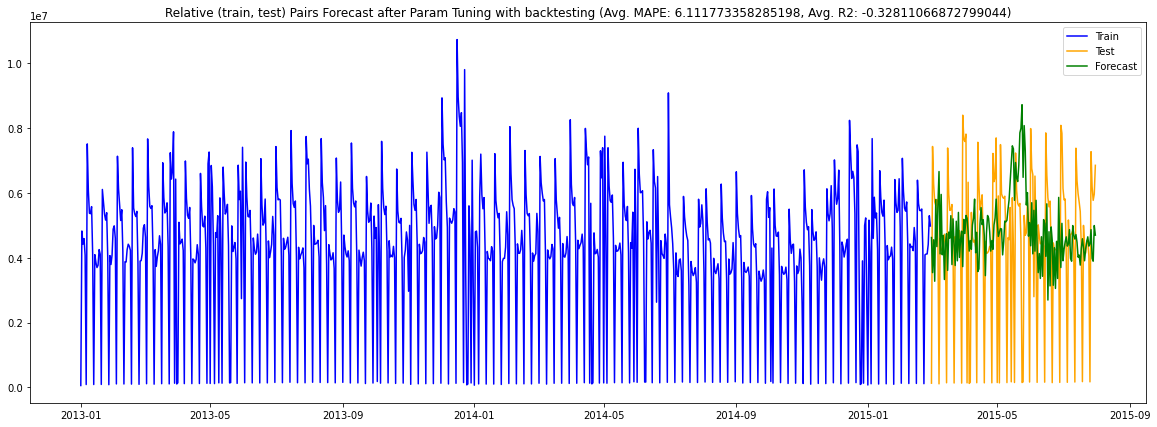

In [19]:
avg_mape, avg_r2 = hw_forecast_relative_pairs(ts_df_train, ts_df_test,
                               relative_train_test_pairs, all_performance, 
                               title='Relative (train, test) Pairs Forecast after Param Tuning with backtesting')

summarized_performance[3] = {'Experiment': 'Relative (train, test) Pairs', 'MAPE': avg_mape, 'R2': avg_r2}

## Adjustable Rolling Window

* In every (train, valid) pair, it will try to adjust the params of the model through grid search on its previous (train, valid) pair. The final selected params came from the (train, valid) pair that got the best performance.

In [20]:
def adjustable_grid_search(initial_mape, train, valid, grid_params):
    """
    Find params that can improve the best performance of previous (train, valid) pairs, otherwise return None.
    
    @param initial_mape: initial performance from previous (train, valid) pairs
    @param train: the training data
    @param valid: the validation data
    @param grid_params: a list of all the params choices
    @return: the params that can further improvement the performance, otherwise return None
    """
    best_params = None
    best_mape = initial_mape
    
    for params in grid_params:        
        try:
            model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=params[0], trend=params[1], 
                                             seasonal=params[2], damped=params[3]).fit(smoothing_level = params[4], smoothing_slope = params[5])
            y_pred = model_fit.forecast(len(valid))
            
            sub_mape = mape(valid, y_pred)
            if sub_mape < initial_mape:
                best_params = params
                best_mape = sub_mape
        except:
            continue
            
    return best_params, best_mape


@get_runtime
def get_adjustable_selected_params(params_dct, default_params, rolling_window_train_valid_dct):
    """
    Get a list of adjusted params from each (trian, valid) pair.
    
    @param param_dct: a dictionary of all the params' choices
    @param default_params: default params before getting any adjusted params
    @param rolling_window_train_valid_dct: the dictionary that stores every (train, valid) pair
    @return: a list of adjusted params and a list of optimized performance results
    """
    best_params_lst = []
    best_mape_lst = []
    
    # list all the param sets for the grid search
    grid_params = list(itertools.product(params_dct['seasonal_periods'], params_dct['trend'], params_dct['seasonal'],
                                         params_dct['damped'], params_dct['smoothing_level'], params_dct['smoothing_slope']))
    plt.figure(figsize=(20,7))
    
    for idx, train_valid_pairs in rolling_window_train_valid_dct.items():
        train = train_valid_pairs['train']
        valid = train_valid_pairs['valid']
    
        if len(best_params_lst) > 0:
            params = best_params_lst[-1]
            model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=params[0], trend=params[1], 
                                             seasonal=params[2], damped=params[3]).fit(smoothing_level = params[4], smoothing_slope = params[5])
        else:
            model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=default_params['seasonal_periods'], trend=default_params['trend'],
                                             seasonal=default_params['seasonal'], damped=default_params['damped'])\
                        .fit(smoothing_level=default_params['smoothing_level'], smoothing_slope=default_params['smoothing_slope'])
        
        y_pred = model_fit.forecast(len(valid))
        initial_mape = mape(valid, y_pred)
        improved_params, improved_mape = adjustable_grid_search(initial_mape, train, valid, grid_params)
        if improved_params:
            best_params_lst.append(improved_params)
            best_mape_lst.append(improved_mape)
            
        plt.plot(train.index, train, label='Train', color='blue')
        plt.plot(valid.index, valid, label='Valid', color='orange')
        plt.plot(valid.index, y_pred, label='Forecast', color='green')
        if idx == 0:
            plt.legend(loc='best')
            
    plt.title(f"Adjustable Forecast on Each (train, valid) Pair - Average Validation MAPE is {np.mean(best_mape_lst)}")
    plt.show()
    
    return best_params_lst, best_mape_lst

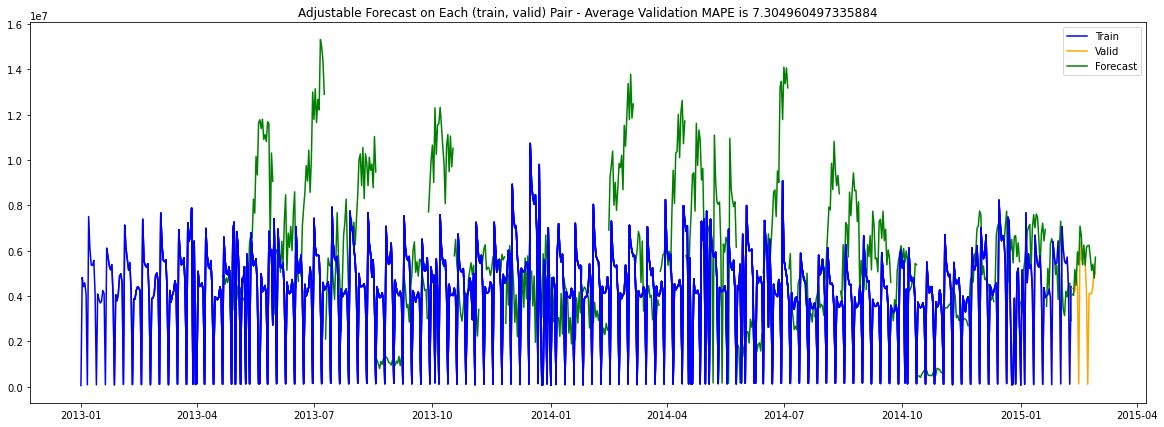

Execution Time: 745.8221687999999 seconds


In [21]:
params_dct = {
    'seasonal_periods': [20, 30, 40],  # make sure this value is no longer than the training data used in the model
    'trend': ['add', 'mul'],
    'seasonal': ['mul'],
    'damped': [True],
    'smoothing_level': [0.2, 0.6, 0.8, 0.9],
    'smoothing_slope': [0.2, 0.4, 0.6, 0.8]
}
default_params = {'seasonal_periods': 30, 'trend': 'mul', 'seasonal': 'mul', 'damped': True, 'smoothing_level': 0.9, 'smoothing_slope': 0.2}

best_params_lst, best_mape_lst = get_adjustable_selected_params(params_dct, default_params, rolling_window_train_valid_dct)

### Use the Most Frequent Selected Params

* The selected params is trained in the whole training data

[((40, 'mul', 'mul', True, 0.9, 0.8), 10)]


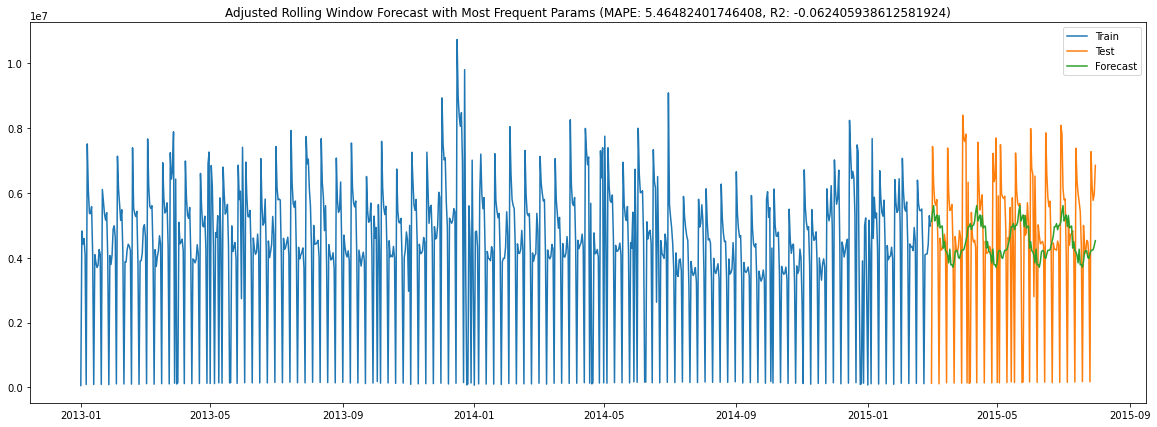

In [22]:
c = Counter(best_params_lst)
mode_params = c.most_common(1)
print(mode_params)

selected_params4 = {'seasonal_periods': mode_params[0][0][0], 'trend': mode_params[0][0][1], 'seasonal': mode_params[0][0][2],
                    'damped': mode_params[0][0][3], 'smoothing_level': mode_params[0][0][4], 'smoothing_slope': mode_params[0][0][5]}
adjustable_freq_mape, adjustable_freq_r2 = hw_forecast(ts_df_train, ts_df_test, selected_params4, title='Adjusted Rolling Window Forecast with Most Frequent Params')

summarized_performance[4] = {'Experiment': 'Adjusted Rolling Window Frequent', 'MAPE': adjustable_freq_mape, 'R2': adjustable_freq_r2}

### Use the Latest Selected Params

* Option 1 - The selected params is trained in the recent training data
* Option 2 - The selected params is trained in the whole training data

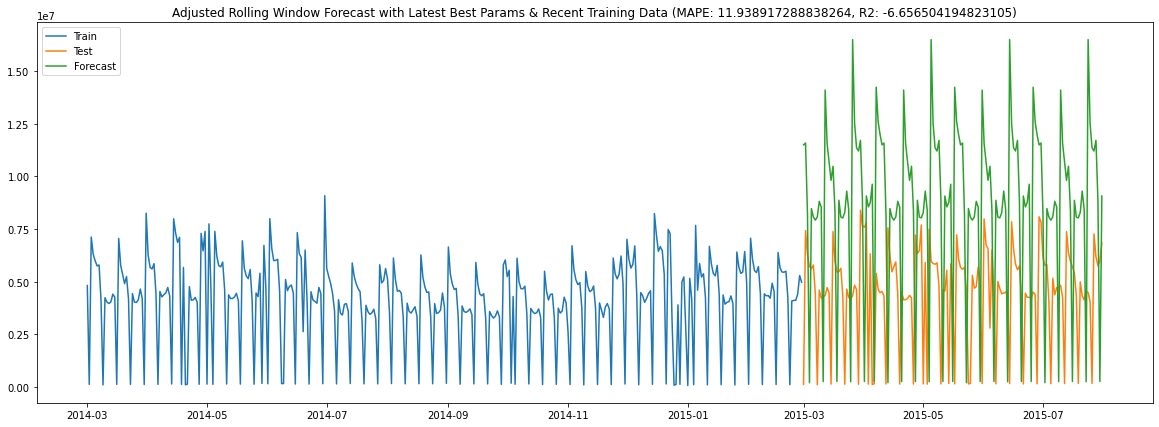

In [23]:
latest_params = best_params_lst[-1]

selected_params5 = {'seasonal_periods': latest_params[0], 'trend': latest_params[1], 'seasonal': latest_params[2],
                    'damped': latest_params[3], 'smoothing_level': latest_params[4], 'smoothing_slope': latest_params[5]}

adjustable_latest_mape_recent, adjustable_latest_r2_recent = hw_forecast(ts_df_train_sub, ts_df_test, selected_params5, title='Adjusted Rolling Window Forecast with Latest Best Params & Recent Training Data')
summarized_performance[5] = {'Experiment': 'Adjusted Rolling Window Latest Recent', 'MAPE': adjustable_latest_mape_recent, 'R2': adjustable_latest_r2_recent}

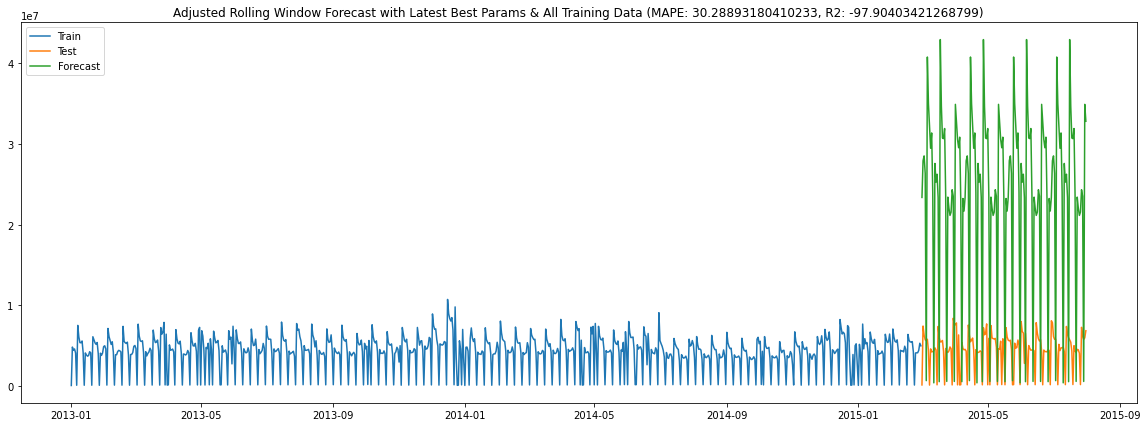

In [24]:
adjustable_latest_mape_all, adjustable_latest_r2_all= hw_forecast(ts_df_train, ts_df_test, selected_params5, title='Adjusted Rolling Window Forecast with Latest Best Params & All Training Data')
summarized_performance[6] = {'Experiment': 'Adjusted Rolling Window Latest All', 'MAPE': adjustable_latest_mape_all, 'R2': adjustable_latest_r2_all}

## Subset Training Forecast

* Choose the most recent historical data as the training data
* Param tuning with backtesting
* The risk of this method is, the training data is not large enough to cover the seasonal periods or can't provide enough input for backtesting

In [25]:
params_dct = {
    'seasonal_periods': [30, 40, 50],
    'trend': ['add', 'mul'],
    'seasonal': ['mul'],
    'damped': [True],
    'smoothing_level': [0.2, 0.6, 0.8, 0.9],
    'smoothing_slope': [0.2, 0.4, 0.6, 0.8]
}

selected_params7 = hw_grid_search_backtest(params_dct, ts_df_train_sub, int(len(ts_df_test)/2), 3)

After trying 96 param sets, got best average MAPE as 4.024629350641869 through param set {'seasonal_periods': 30, 'trend': 'add', 'seasonal': 'mul', 'damped': True, 'smoothing_level': 0.6, 'smoothing_slope': 0.4}
Execution Time: 119.15776340000002 seconds


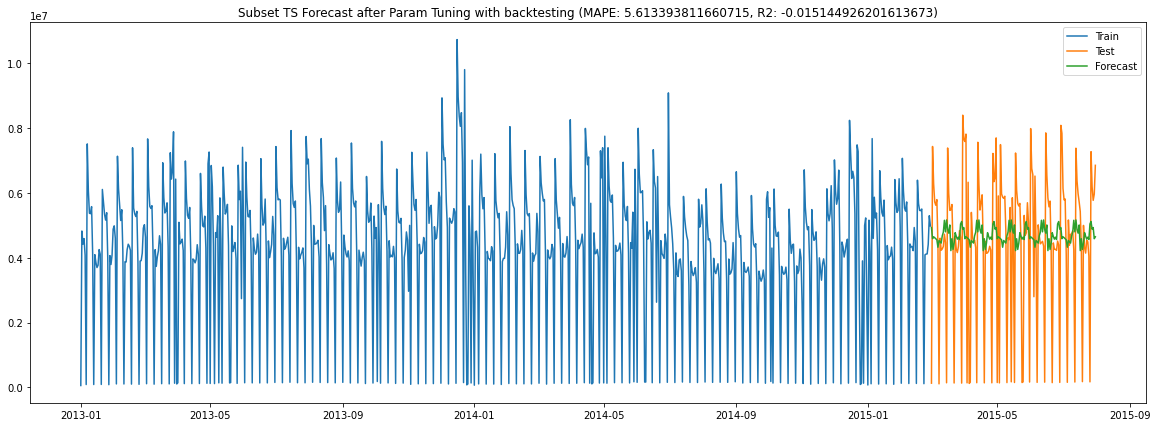

In [26]:
sub_pred_mape_hpo_bt, sub_pred_r2_hpo_bt = hw_forecast(ts_df_train, ts_df_test, selected_params7, title='Subset TS Forecast after Param Tuning with backtesting')

summarized_performance[7] = {'Experiment': 'Subset Sequence HPO with Backtesting', 'MAPE': sub_pred_mape_hpo_bt, 'R2': sub_pred_r2_hpo_bt}

## Summary

In [27]:
summarized_performance_df = pd.DataFrame(summarized_performance).T
summarized_performance_df = summarized_performance_df.sort_values(by='MAPE')
summarized_performance_df

,Experiment,MAPE,R2
0,Whole Sequence without HPO,5.340704,-0.07334
4,Adjusted Rolling Window Frequent,5.464824,-0.062406
7,Subset Sequence HPO with Backtesting,5.613394,-0.015145
2,Whole Sequence HPO with Backtesting,5.716192,-0.119214
3,"Relative (train, test) Pairs",6.111773,-0.328111
1,Whole Sequence HPO without Backtesting,7.160332,-0.531621
5,Adjusted Rolling Window Latest Recent,11.938917,-6.656504
6,Adjusted Rolling Window Latest All,30.288932,-97.904034
